In [1]:
#pip install captcha

Note: you may need to restart the kernel to use updated packages.


## Generate CAPTCHA Characters for Testing

### Prepare Directories

In [2]:
import os
import shutil

# Create the following directories and ensure that they are empty
for directory in list([
    "captcha_phrases",
    "captcha_phrases_no_noise",
    "captcha_phrases_segmented",
    "captcha_phrases_training"]):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory, exist_ok=True)

### Generate Random CAPTCHAS 

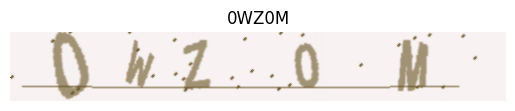

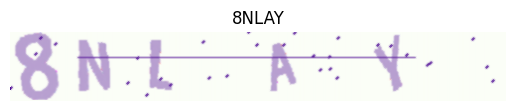

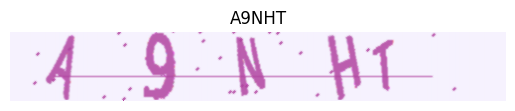

In [3]:
import os
import string
import random
import matplotlib.pyplot as plt
from captcha.image import ImageCaptcha

# Generate a string of random uppercase letters and digits
def generate_random_string(length):
    characters = string.ascii_uppercase + string.digits
    return ' '.join(random.choice(characters) for _ in range(length))

# Parameters
string_length = 5
samples = 10
image_width = 100 * string_length
image_height = 70
output_dir = 'captcha_phrases'

for sample in range(samples):
    # Generate a CAPTCHA
    captcha_text = generate_random_string(string_length)
    captcha = ImageCaptcha(width=image_width, height=image_height)
    captcha_image = captcha.generate_image(captcha_text)
    captcha_text = captcha_text.replace(' ', '')

    # Save CAPTCHA as PNG
    filename = os.path.join(output_dir, f'{captcha_text}.png')
    captcha_image.save(filename)

# Plot
num_images = 3
png_files = sorted([file for file in os.listdir(output_dir) if file.endswith('.png')])[:num_images]

for png_file in png_files:
    image_path = os.path.join(output_dir, png_file)
    image = plt.imread(image_path)
    
    plt.imshow(image, cmap='gray')
    plt.title(png_file[:-4])
    plt.axis('off')
    plt.show()

### Remove Noise

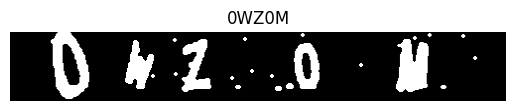

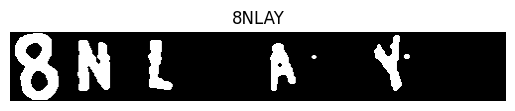

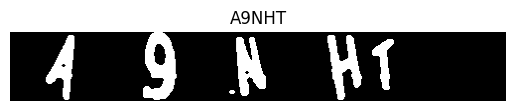

In [4]:
import os
import cv2
import numpy as np

# Parameters
input_dir = "captcha_phrases"
output_dir = "captcha_phrases_no_noise"

for filename in os.listdir(input_dir):
    if filename.endswith(".png"):
        # Convert CAPTCHA to greyscale then make black or white with a threshold
        image = cv2.imread(os.path.join(input_dir, filename), cv2.IMREAD_GRAYSCALE)
        _, binarized = cv2.threshold(image, 230, 255, cv2.THRESH_BINARY_INV)
        
        # Remove pixels with erosion to weaken noise
        kernel = np.ones((3, 3), np.uint8)
        eroded = cv2.erode(binarized, kernel, iterations=1)
        
        # Remove pixels with a median filter to weaken vertical and horizontal lines
        median_filtered = cv2.medianBlur(eroded, 3)
        horizontal_kernel = np.ones((1, 5), np.uint8)
        horizontal_filtered = cv2.morphologyEx(median_filtered, cv2.MORPH_CLOSE, horizontal_kernel)
        
        # Add pixels with dilation to thicken letters and digits
        dilation_kernel = np.ones((3, 3), np.uint8)
        dilated = cv2.dilate(horizontal_filtered, dilation_kernel, iterations=1)
        
        # Remove pixels with a median filter again for good measure
        result = cv2.medianBlur(dilated, 3)
        
        # Save processed CAPTCHA as PNG
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, result)
        
# Plot
num_images = 3
png_files = sorted([file for file in os.listdir(output_dir) if file.endswith('.png')])[:num_images]

for png_file in png_files:
    image_path = os.path.join(output_dir, png_file)
    image = plt.imread(image_path)
    
    plt.imshow(image, cmap='gray')
    plt.title(png_file[:-4])
    plt.axis('off')
    plt.show()

### Segment Characters Part 1

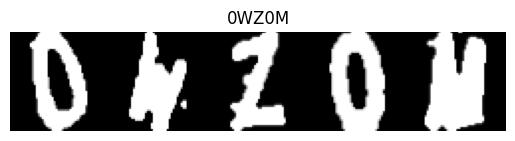

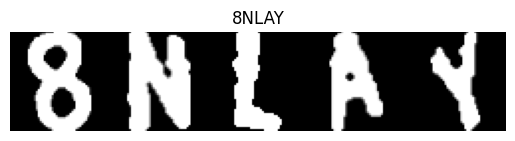

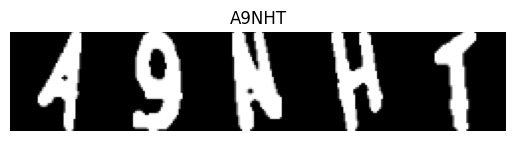

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parameters
string_length = 5
input_dir = "captcha_phrases_no_noise"
output_dir = "captcha_phrases_segmented"

for filename in os.listdir(input_dir):
    if filename.endswith(".png"):
        # Read CAPTCHA as grayscale
        image = cv2.imread(os.path.join(input_dir, filename), cv2.IMREAD_GRAYSCALE)
        
        # Find contours and filter any small contours (noise)
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 100]
        
        # Sort contours from left to right and only keep the specified number
        filtered_contours = sorted(filtered_contours, key=lambda contour: cv2.boundingRect(contour)[0])
        num_contours = min(len(filtered_contours), string_length)
        
        # Initialize a black background for the output
        segmented_canvas = np.zeros((50, 50 * num_contours), dtype=np.uint8)
        
        for i, contour in enumerate(filtered_contours[:num_contours]):
            x, y, w, h = cv2.boundingRect(contour)
            
            # Calculate the aspect ratio
            aspect_ratio = w / h
            
            # Calculate new width and height to maintain aspect ratio within 50x50 canvas
            new_width = min(50, int(aspect_ratio * 50))
            new_height = min(50, int(50 / aspect_ratio))
            
            # Resize the character to the calculated size and place on the black background
            character = image[y:y+h, x:x+w]
            resized_character = cv2.resize(character, (new_width, new_height))
            x_offset = (50 - new_width) // 2
            y_offset = (50 - new_height) // 2
            segmented_canvas[y_offset:y_offset+new_height, i * 50 + x_offset : i * 50 + x_offset + new_width] = resized_character
        
        # Save processed CAPTCHA as PNG
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, segmented_canvas)
        
# Plot
num_images = 3
png_files = sorted([file for file in os.listdir(output_dir) if file.endswith('.png')])[:num_images]

for png_file in png_files:
    image_path = os.path.join(output_dir, png_file)
    image = plt.imread(image_path)
    
    plt.imshow(image, cmap='gray')
    plt.title(png_file[:-4])
    plt.axis('off')
    plt.show()